In [1]:
!pip install torch torchvision tqdm matplotlib numpy

   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/203.0 MB 796.8 kB/s eta 0:04:15
   ---------------------------------------- 0.8/203.0 MB 882.6 kB/s eta 0:03:50
   ---------------------------------------- 1.0/203.0 MB 898.8 kB/s eta 0:03:45
   ---------------------------------------- 1.0/203.0 MB 898.8 kB/s eta 0:03:45
   ---------------------------------------- 1.3/203.0 MB 808.5 kB/s eta 0:04:10
   ---------------------------------------- 1.3/203.0 MB 808.5 kB/s eta 0:04:10
   ---------------------------------------- 1.3/203.0 MB 808.5 kB/s eta 0:04:10
   ---------------------------------------- 1.6/203.0 MB 742.2 kB/s eta 0:04:32
   --

# **Import Libraries and Setup**

In [2]:
# Import Libraries and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# **Data Preprocessing and Augmentation**

In [3]:
# Data Preprocessing and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# **Data Loading**

In [ ]:
# import os

# # Set data_dir relative to the script's location
# data_dir = os.path.join(os.path.dirname(__file__), 'Fruits Classification')


NameError: name '__file__' is not defined

In [16]:
# Data Loading
# Set the correct path for Kaggle
data_dir = r'C:\Users\numit\OneDrive\Desktop\project\New folder (3)\new\Fruits Classification'


# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['test','train', 'valid' ]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print("\nDataset Information:")
print(f"Classes: {class_names}")
print("\nDataset sizes:")
for phase in dataset_sizes:
    print(f"{phase}: {dataset_sizes[phase]} images")


Dataset Information:
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

Dataset sizes:
train: 9700 images
valid: 200 images
test: 100 images


# **Data Visualization**


Displaying sample images from training set:


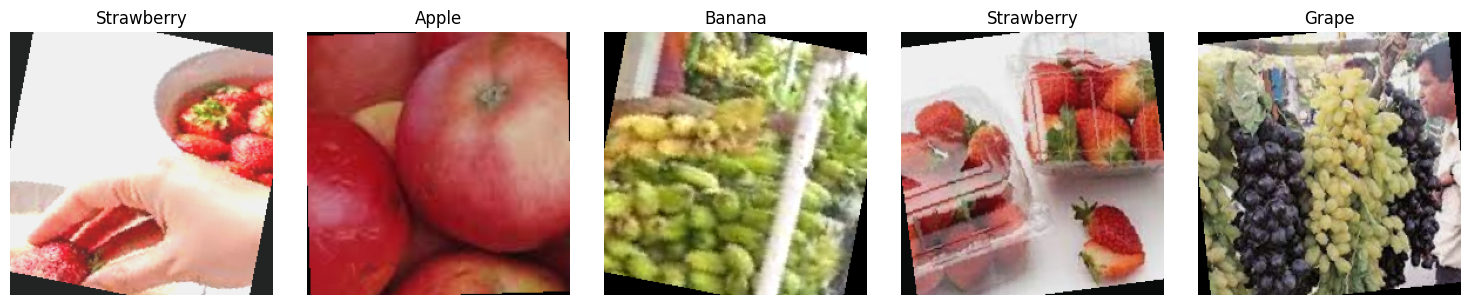

In [19]:
# Data Visualization
def show_samples(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i, (ax, image, label) in enumerate(zip(axes, images, labels)):
        image = image.numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        ax.imshow(image)
        ax.set_title(f'{class_names[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images from training set:")
show_samples(dataloaders['train'])

# **Model Architecture**

In [20]:
# Model Architecture
def initialize_model():
    model = models.resnet50(pretrained=True)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, len(class_names))
    )
    
    return model

# **Training Function**

In [21]:
# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = None
    best_acc = 0.0
    
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                valid_losses.append(epoch_loss)
                valid_accs.append(epoch_acc.cpu())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
    
    print(f'\nBest val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(valid_accs, label='Validation')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

# **Model Training Setup and Execution**


Initializing model...


c:\Users\numit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\numit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\numit/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:35<00:00, 1.08MB/s]



Starting training...

Epoch 1/15
----------


train: 100%|██████████| 304/304 [09:56<00:00,  1.96s/it]


train Loss: 0.9057 Acc: 0.6524


valid: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


valid Loss: 0.5293 Acc: 0.8050

Epoch 2/15
----------


train: 100%|██████████| 304/304 [08:31<00:00,  1.68s/it]


train Loss: 0.7343 Acc: 0.7247


valid: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


valid Loss: 0.4485 Acc: 0.8500

Epoch 3/15
----------


train: 100%|██████████| 304/304 [08:32<00:00,  1.69s/it]


train Loss: 0.6891 Acc: 0.7463


valid: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


valid Loss: 0.3940 Acc: 0.8550

Epoch 4/15
----------


train: 100%|██████████| 304/304 [08:35<00:00,  1.69s/it]


train Loss: 0.6763 Acc: 0.7492


valid: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


valid Loss: 0.4137 Acc: 0.8550

Epoch 5/15
----------


train: 100%|██████████| 304/304 [5:07:41<00:00, 60.73s/it]     


train Loss: 0.6576 Acc: 0.7567


valid: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


valid Loss: 0.4102 Acc: 0.8400

Epoch 6/15
----------


train: 100%|██████████| 304/304 [07:29<00:00,  1.48s/it]


train Loss: 0.6492 Acc: 0.7563


valid: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


valid Loss: 0.4047 Acc: 0.8650

Epoch 7/15
----------


train: 100%|██████████| 304/304 [07:45<00:00,  1.53s/it]


train Loss: 0.6368 Acc: 0.7671


valid: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


valid Loss: 0.3939 Acc: 0.8500

Epoch 8/15
----------


train: 100%|██████████| 304/304 [12:16<00:00,  2.42s/it]


train Loss: 0.5887 Acc: 0.7827


valid: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


valid Loss: 0.3583 Acc: 0.8600

Epoch 9/15
----------


train: 100%|██████████| 304/304 [08:13<00:00,  1.62s/it]


train Loss: 0.5611 Acc: 0.7972


valid: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


valid Loss: 0.3726 Acc: 0.8700

Epoch 10/15
----------


train: 100%|██████████| 304/304 [07:44<00:00,  1.53s/it]


train Loss: 0.5603 Acc: 0.7960


valid: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


valid Loss: 0.3852 Acc: 0.8550

Epoch 11/15
----------


train: 100%|██████████| 304/304 [07:56<00:00,  1.57s/it]


train Loss: 0.5609 Acc: 0.7997


valid: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


valid Loss: 0.3726 Acc: 0.8550

Epoch 12/15
----------


train: 100%|██████████| 304/304 [08:36<00:00,  1.70s/it]


train Loss: 0.5396 Acc: 0.8069


valid: 100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


valid Loss: 0.3557 Acc: 0.8650

Epoch 13/15
----------


train: 100%|██████████| 304/304 [08:28<00:00,  1.67s/it]


train Loss: 0.5512 Acc: 0.8015


valid: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


valid Loss: 0.3556 Acc: 0.8700

Epoch 14/15
----------


train: 100%|██████████| 304/304 [07:37<00:00,  1.51s/it]


train Loss: 0.5483 Acc: 0.8028


valid: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


valid Loss: 0.3392 Acc: 0.8700

Epoch 15/15
----------


train: 100%|██████████| 304/304 [07:40<00:00,  1.52s/it]


train Loss: 0.5440 Acc: 0.8075


valid: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


valid Loss: 0.3532 Acc: 0.8700

Best val Acc: 0.870000


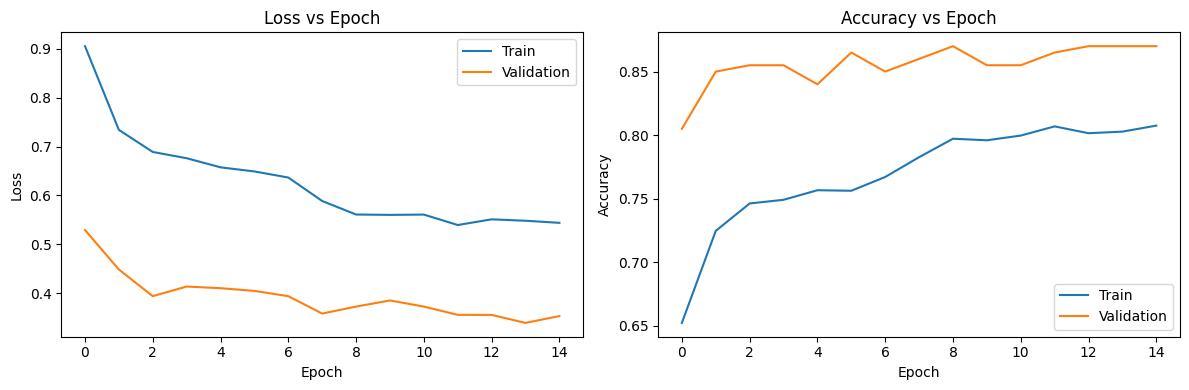

In [22]:
# Model Training Setup and Execution
print("\nInitializing model...")
model = initialize_model()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("\nStarting training...")
model = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

# **Model Evaluation**

In [23]:
# Model Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {acc:.4f}')
    
    return all_preds, all_labels

print("\nEvaluating on test set...")
test_preds, test_labels = evaluate_model(model, dataloaders['test'])


Evaluating on test set...


Testing: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]

Test Accuracy: 0.9100



Testing image from URL: https://www.heddensofwoodtown.co.uk/wp-content/uploads/2020/05/grapes_green_opt.jpg


C:\Users\numit\AppData\Local\Temp\ipykernel_12304\3102411183.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(class_names, rotation=45)


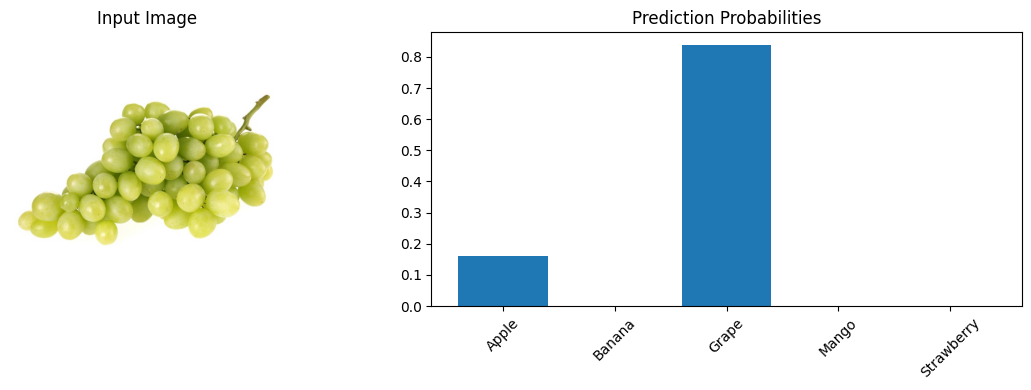


Predicted class: Grape

Class probabilities:
Apple: 0.1617
Banana: 0.0000
Grape: 0.8371
Mango: 0.0012
Strawberry: 0.0000

Testing image from URL: https://static.libertyprim.com/files/familles/pomme-large.jpg


C:\Users\numit\AppData\Local\Temp\ipykernel_12304\3102411183.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(class_names, rotation=45)


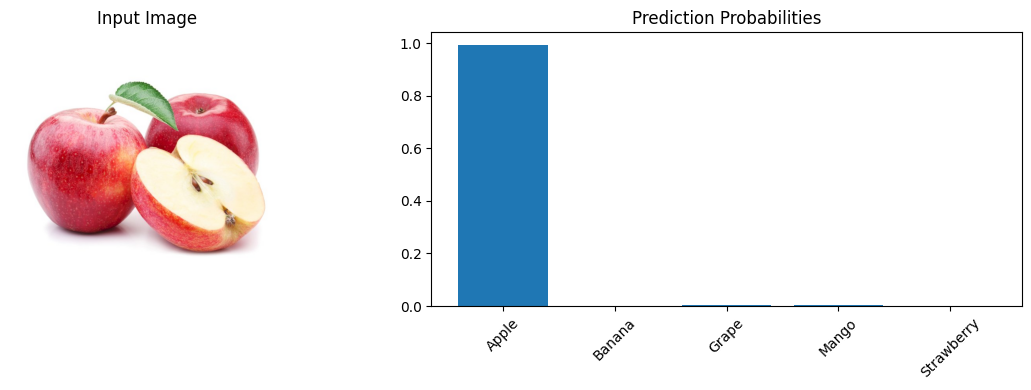


Predicted class: Apple

Class probabilities:
Apple: 0.9910
Banana: 0.0011
Grape: 0.0048
Mango: 0.0025
Strawberry: 0.0006

Testing image from URL: https://hermie.com/media/56/28/cf/1720431526/280e510e31647832f5e55b532a3d21fc.jpg


C:\Users\numit\AppData\Local\Temp\ipykernel_12304\3102411183.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(class_names, rotation=45)


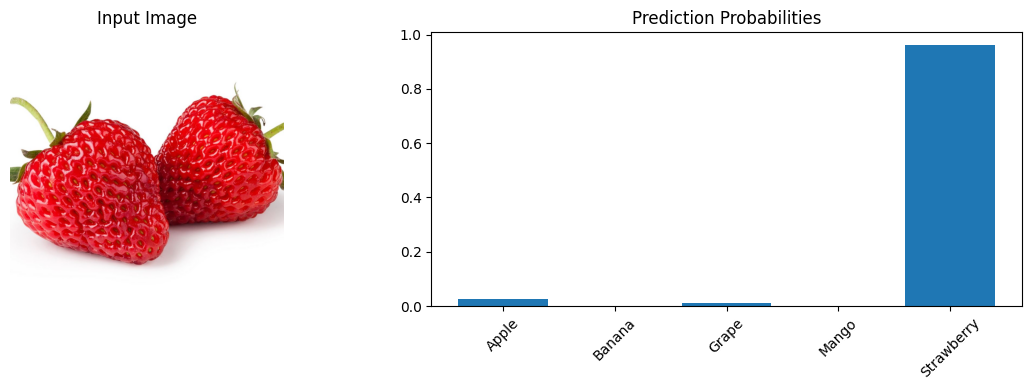


Predicted class: Strawberry

Class probabilities:
Apple: 0.0261
Banana: 0.0016
Grape: 0.0107
Mango: 0.0011
Strawberry: 0.9605

Testing image from URL: https://images.pexels.com/photos/5945848/pexels-photo-5945848.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1


C:\Users\numit\AppData\Local\Temp\ipykernel_12304\3102411183.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(class_names, rotation=45)


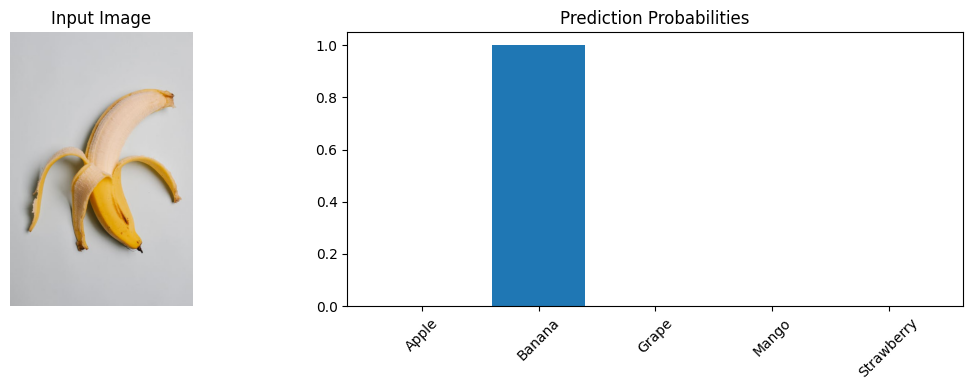


Predicted class: Banana

Class probabilities:
Apple: 0.0000
Banana: 1.0000
Grape: 0.0000
Mango: 0.0000
Strawberry: 0.0000


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def test_image_from_url(url):
    try:
        # Download and open the image
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        
        # Preprocess the image
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Transform image
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)
        
        # Move to device (CPU/GPU)
        input_batch = input_batch.to(device)
        model.to(device)
        
        # Set model to evaluation mode and get prediction
        model.eval()
        with torch.no_grad():
            output = model(input_batch)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)
            predicted_class = class_names[output.argmax().item()]
        
        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Display image
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Input Image')
        
        # Display probabilities
        probs = probabilities.cpu().numpy()
        ax2.bar(class_names, probs)
        ax2.set_xticklabels(class_names, rotation=45)
        ax2.set_title('Prediction Probabilities')
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"\nPredicted class: {predicted_class}")
        print("\nClass probabilities:")
        for class_name, prob in zip(class_names, probs):
            print(f"{class_name}: {prob:.4f}")
            
    except Exception as e:
        print(f"Error: {str(e)}")

# Test URLs
urls = [
    "https://www.heddensofwoodtown.co.uk/wp-content/uploads/2020/05/grapes_green_opt.jpg",
    "https://static.libertyprim.com/files/familles/pomme-large.jpg",
    "https://hermie.com/media/56/28/cf/1720431526/280e510e31647832f5e55b532a3d21fc.jpg",
    "https://images.pexels.com/photos/5945848/pexels-photo-5945848.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1",
    

]

# Test each image
for url in urls:
    print(f"\nTesting image from URL: {url}")
    test_image_from_url(url)

# **Save Model and Final Summary**

In [39]:
# Save Model and Final Summary

save_path = r'C:\Users\numit\OneDrive\Desktop\project\New folder (3)\new\numita.pkl'

torch.save(model.state_dict(), save_path)

print("\nTraining completed!")
print(f"Model saved at: {save_path}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")




Training completed!
Model saved at: C:\Users\numit\OneDrive\Desktop\project\New folder (3)\new\numita.pkl
Number of classes: 5
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [40]:
try:
    model.load_state_dict(torch.load(save_path))
    print("Model successfully loaded!")
except FileNotFoundError:
    print(f"Error: The file '{save_path}' was not found.")


Model successfully loaded!


C:\Users\numit\AppData\Local\Temp\ipykernel_12304\980051707.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [32]:
# Section 10: Prediction Function (Optional)
def predict_image(image_path, model):
    from PIL import Image
    
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = data_transforms['test']
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        
    return class_names[predicted.item()]